<a href="https://colab.research.google.com/github/romainjulian/ProgrammingAssignment2/blob/master/M%C3%A9moire_BELARBI_JULIAN_PART_3_Section_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PART 3 - SECTION 3: Utilisation du Deep Learning pour répliquer et battre le marché**

Ici, on ne cherche pas à prédire mais à séléctionner

In [0]:
# Librairies and pakcages
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Data
from google.colab import files
import io
stock = defaultdict(defaultdict)

# Stocks composant l'index
#Fichier des cours de cloture ajusté des dividendes des stocks composant le CAC 40
uploaded = files.upload()
stock_lp_file = pd.read_excel(io.BytesIO(uploaded['stock_cac40_adj_close.xlsx']), index_col=0).astype('float32')

#Fichier des rendements des cours adj close des stocks composant le CAC 40
uploaded = files.upload()
stock_net_file = pd.read_excel(io.BytesIO(uploaded['stock_cac40_rdmt.xlsx']), index_col=0).astype('float32')

#Fichier des varaitions relatives des cours adj close des stocks composant le CAC 40
uploaded = files.upload()
stock_percentage_file = pd.read_excel(io.BytesIO(uploaded['stock_cac40_change.xlsx']), index_col=0).astype('float32')

#Index CAC 40 - cours de cloture adj close (représentant le marché)
uploaded = files.upload()
cac40_file = pd.read_excel(io.BytesIO(uploaded['cac_40.xlsx']), index_col=0).astype('float32')


In [0]:
#Créer les échantillons pour calibrer et valider les données

training_len= math.ceil(len(cac40_file)*.8)

stock_lp_file=stock_lp_file.fillna(method='bfill')
stock_net_file=stock_net_file.fillna(method='bfill')
stock_percentage_file=stock_percentage_file.fillna(method='bfill')
cac40_file=cac40_file.fillna(method='bfill')

stock['calibrate']['lp'] = stock_lp_file.iloc[0:training_len, :]
stock['validate']['lp'] = stock_lp_file.iloc[training_len:, :]

stock['calibrate']['net'] = stock_net_file.iloc[0:training_len, :]
stock['validate']['net'] = stock_net_file.iloc[training_len:, :]

stock['calibrate']['percentage'] = stock_percentage_file.iloc[0:training_len, :]
stock['validate']['percentage'] = stock_percentage_file.iloc[training_len:, :]


cac40_lp = cac40_file.iloc[:,0] 
cac40['calibrate']['lp'] = cac40_lp[0:training_len]
cac40['validate']['lp'] = cac40_lp[training_len-1:]

cac40_net = cac40_file.iloc[:,1] 
cac40['calibrate']['net'] = cac40_net[0:training_len]
cac40['validate']['net'] = cac40_net[training_len:]

cac40_percentage = cac40_file.iloc[:,2] 
cac40['calibrate']['percentage'] = cac40_percentage[0:training_len]
cac40['validate']['percentage'] = cac40_percentage[training_len:]



NameError: ignored

# **A. Recréer l'indice CAC 40 **
Ici le CAC 40 est l'index qui représente le marché
On tente dans cette partie de séléctionner des sous échantillons de stocks compossant le CAC 40 qui pourrait le répliquer
Ainsi, on pourrait avoir les meme remndements du CAC avec des portfeuille moins cher


**Phase 1. Auto-encoding**

Entrainer un model auto-encoder: c'est à dire la fonction avec laquelle on minimise la différence entre le marché et le stock, en d'autres terme, trouver qu'elle stock explique le plus/s'approche le plus/ impact le plus le marché

On se base sur une mesure appellée "2-norm difference" qu'on cherche a minimiser: plus ce citère sera réduit, plus le stock aura un role important dans la fonction auto-encoder du marché

C'est avec ce critère qu'on va calsser nos stocks en ordre croissant afin de séléctionner les sous echantillons



In [0]:
encoding_dim = 5 # 5 neurones
num_stock = len(stock_lp_file.columns) # 40 stock qui composent le CAC 40

# Connection des neuronnes
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) 

# Construction et compilation de l'auto encodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# Entrainement
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=100, batch_size = 10)
autoencoder.save('retrack_autoencoder.h5')

# Predictions
reconstruct = autoencoder.predict(data)
reconstruct


Epoch 1/100
1630/1630 [==============================] - 0s 118us/step - loss: 0.1702
Epoch 2/100
1630/1630 [==============================] - 0s 99us/step - loss: 0.1595
Epoch 3/100
1630/1630 [==============================] - 0s 89us/step - loss: 0.1494
Epoch 4/100
1630/1630 [==============================] - 0s 88us/step - loss: 0.1400
Epoch 5/100
1630/1630 [==============================] - 0s 89us/step - loss: 0.1311
Epoch 6/100
1630/1630 [==============================] - 0s 91us/step - loss: 0.1229
Epoch 7/100
1630/1630 [==============================] - 0s 91us/step - loss: 0.1151
Epoch 8/100
1630/1630 [==============================] - 0s 92us/step - loss: 0.1079
Epoch 9/100
1630/1630 [==============================] - 0s 90us/step - loss: 0.1011
Epoch 10/100
1630/1630 [==============================] - 0s 93us/step - loss: 0.0947
Epoch 11/100
1630/1630 [==============================] - 0s 106us/step - loss: 0.0888
Epoch 12/100
1630/1630 [==============================] - 0s 

array([[0.00061256, 0.00072467, 0.00029655, ..., 0.00065503, 0.00037025,
        0.00066794],
       [0.00059888, 0.00071863, 0.00029147, ..., 0.00064136, 0.00036211,
        0.00067243],
       [0.00060443, 0.00072108, 0.00029353, ..., 0.00064691, 0.00036541,
        0.00067061],
       ...,
       [0.0006105 , 0.00072376, 0.00029578, ..., 0.00065297, 0.00036903,
        0.00066862],
       [0.00060326, 0.00072057, 0.0002931 , ..., 0.00064575, 0.00036472,
        0.00067099],
       [0.00060052, 0.00071936, 0.00029208, ..., 0.000643  , 0.00036309,
        0.00067189]], dtype=float32)

In [0]:
#Prediction pour chaque stock
reconstruct

array([[0.00061256, 0.00072467, 0.00029655, ..., 0.00065503, 0.00037025,
        0.00066794],
       [0.00059888, 0.00071863, 0.00029147, ..., 0.00064136, 0.00036211,
        0.00067243],
       [0.00060443, 0.00072108, 0.00029353, ..., 0.00064691, 0.00036541,
        0.00067061],
       ...,
       [0.0006105 , 0.00072376, 0.00029578, ..., 0.00065297, 0.00036903,
        0.00066862],
       [0.00060326, 0.00072057, 0.0002931 , ..., 0.00064575, 0.00036472,
        0.00067099],
       [0.00060052, 0.00071936, 0.00029208, ..., 0.000643  , 0.00036309,
        0.00067189]], dtype=float32)

In [0]:
#Classement en fonctions des 2 norm differences
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
print(ranking)
l=[]
for stock_index in ranking:
    l.append(communal_information[stock_index])
    print(stock_index, communal_information[stock_index], stock['calibrate']['lp'].iloc[:,stock_index].name) # print stock name from lowest different to highest
l
np.sum(l[0:10])

stock #, 2-norm, stock name
[12 26  5 34 23  2 11 36 27 19 17 25 30 15 10 29  4 14 38 21 20 24 18  8
  0 33 31 37  7 13  3  9  6 28  1 16 32 39 35 22]
12 0.24280989170074463 EL.PA
26 0.47765129804611206 RI.PA
5 0.4827306568622589 BN.PA
34 0.4934251606464386 SW.PA
23 0.5025155544281006 OR.PA
2 0.5047855377197266 AI.PA
11 0.5069549083709717 DSY.PA
36 0.5223372578620911 URW.AS
27 0.524773359298706 RMS.PA
19 0.5319603085517883 LR.PA
17 0.5344793796539307 HO.PA
25 0.5572975277900696 PUB.PA
30 0.5583149194717407 SAN.PA
15 0.5604584813117981 FP.PA
10 0.5653395056724548 DG.PA
29 0.5844979882240295 SAF.PA
4 0.5879302024841309 ATO.PA
14 0.5899583101272583 ENGI.PA
38 0.5956762433052063 VIV.PA
21 0.601983904838562 ML.PA
20 0.6144760847091675 MC.PA
24 0.6441754698753357 ORA.PA
18 0.6477932333946228 KER.PA
8 0.6559593081474304 CAP.PA
0 0.661931574344635 AC.PA
33 0.6750124096870422 SU.PA
31 0.6835849285125732 SGO.PA
37 0.686249852180481 VIE.PA
7 0.6895127892494202 CA.PA
13 0.6936585307121277 EN.PA
3 

4.7899439334869385

**Phase 2. Calibrating - étalonnage**

On fixe un objectif, ici le marché, pour vérifier si les prédictions du modèles reflettent les probabilités réelles des résultats. 
Permet de mesurer la "confiance" des résulats et leur "véracité" (c'est à dire leur probabilité de réellment se produire)


In [0]:
## Save future files to your drive
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive"

Mounted at /content/drive
/content/drive/My Drive


In [0]:

cac40_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [0, 10, 20]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = ranking[0:s]# portfolio index
    print(stock_index)
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = cac40['calibrate']['percentage']

    x_bis = stock['validate']['percentage'].iloc[:, stock_index]
    y_bis = cac40['validate']['percentage']

    dl_scaler[s] = StandardScaler()       
    dl_scaler[s].fit(x)
    dl_scaler[s].fit(x_bis)
    x = dl_scaler[s].transform(x)
    x_bis=  dl_scaler[s].transform(x_bis)
    x=np.array(x)
    x_bis=np.array(x_bis)

    deep_learner.fit(x, y, shuffle=False, epochs=10, batch_size = 10)    # fit the model
    deep_learner.save('output/retrack_s' + str(s) + '.h5') # for validation phase use
     # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1

    relative_percentage_bis= copy.deepcopy(deep_learner.predict(x_bis))

    relative_percentage_bis[0] = 0
    relative_percentage_bis= (relative_percentage_bis /100) + 1

    cac40_predict['calibrate'][s] = cac40['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((np.array(cac40_predict['calibrate'][s]) - cac40['calibrate']['lp']))


[12 26  5 34 23  2 11 36 27 19]
Epoch 1/10
1630/1630 [==============================] - 0s 98us/step - loss: 0.1802
Epoch 2/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0752
Epoch 3/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0554
Epoch 4/10
1630/1630 [==============================] - 0s 80us/step - loss: 0.0465
Epoch 5/10
1630/1630 [==============================] - 0s 80us/step - loss: 0.0409
Epoch 6/10
1630/1630 [==============================] - 0s 75us/step - loss: 0.0367
Epoch 7/10
1630/1630 [==============================] - 0s 75us/step - loss: 0.0334
Epoch 8/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0306
Epoch 9/10
1630/1630 [==============================] - 0s 74us/step - loss: 0.0283
Epoch 10/10
1630/1630 [==============================] - 0s 82us/step - loss: 0.0262
[12 26  5 34 23  2 11 36 27 19 17 25 30 15 10 29  4 14 38 21]
Epoch 1/10
1630/1630 [==============================] - 0s 102us/

S10 2-norm difference:  54275.992
S20 2-norm difference:  56187.008
S30 2-norm difference:  54236.766


Text(0.5, -0.3, ' ')

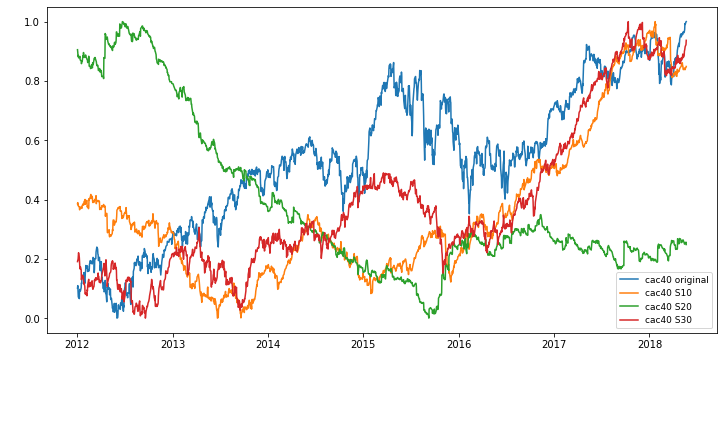

In [0]:
#Nous aimerions maintenant voir à quel point ces 3 portefeuilles sont similaires à ceux de l'indice CAC 40 d'origine aux dates de formation.
# Plot les résultats et les 2-norm differences sur les données scaled
scaler=MinMaxScaler(feature_range=(0,1))

plt.clf
plt.figure(figsize=(12,6))
plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(cac40['calibrate']['lp']).values),label='cac40 original')
for s in [10,20,30]:
    plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(cac40_predict['calibrate'][s]).values),label='cac40 S'+str(s))
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    
plt.legend(loc='best', fontsize=9)
plt.xlabel(' ', fontsize=12)
plt.ylabel(' ', fontsize=12)
plt.title(" ", fontsize=15, loc='center', y=-0.3)


**Phase 3. Validation des résultats**

In [0]:

for non_communal in [0, 10, 20]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index =  ranking[0:s] # portfolio index
    

    cac40_predict['validate'][s] = cac40['validate']['lp'] * (relative_percentage_bis.cumprod())  
  
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(cac40_predict['validate'][s])- cac40['validate']['lp']))





S10 2-norm difference:  1318.0789
S20 2-norm difference:  1318.0789
S30 2-norm difference:  1318.0789


Text(0.5, -0.3, ' ')

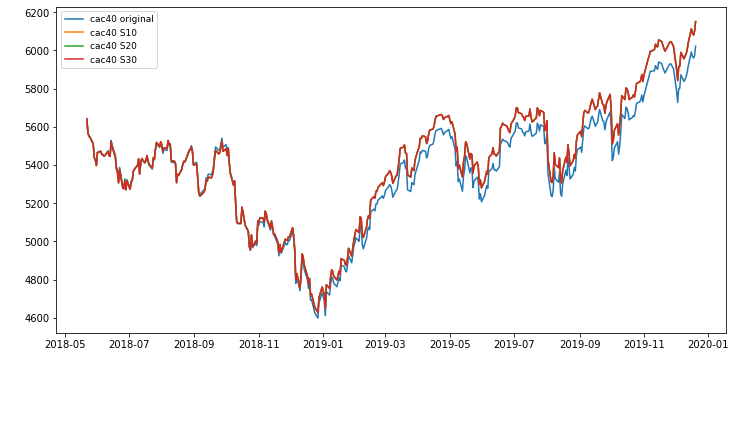

In [0]:
#Une fois encore, on veut voir à quel point ces 3 ptfl sont similaires auà lindice CAC 40 mais cette fois, sur les dates de test 
plt.clf
plt.figure(figsize=(12,6))
plt.plot(cac40_file.index[training_len-1:],cac40['validate']['lp'],label='cac40 original')
for s in [10,20,30]:
    plt.plot(cac40_file.index[training_len-1:],cac40_predict['validate'][s],label='cac40 S'+str(s))
    
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])    
    
plt.legend(loc='best', fontsize=9)
plt.xlabel(' ', fontsize=12)
plt.ylabel(' ', fontsize=12)
plt.title(" ", fontsize=15, loc='center', y=-0.3)


**Phase 4. Vérification**
Après avoir valider les résultats, on verifies si les portefeuilles et le nombre de stocks dedans sont satisfaisant selon le critère de la 2*norm difference
Ici, l'Efficient Deep Frontier n'a rien à voir avec celle de la théorie moderne du portefeuille. 
Elle reflète simplement le compromis entre plus d'actions dans les portefeuilles et une MSE plus élevé.

In [0]:
error = []

for non_communal in range(3, 38, 1):  
    # some numerical values
    encoding_dim = 5
    s =  non_communal
    stock_index = ranking[0:s]# portfolio index


    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')

    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = cac40['calibrate']['percentage']

    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=10, batch_size = 10)    # fit the model

  # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = cac40['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = cac40['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.sqrt(np.linalg.norm((predict_curve - cac40['validate']['lp']))))

Epoch 1/10
1630/1630 [==============================] - 0s 101us/step - loss: 0.1515
Epoch 2/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0565
Epoch 3/10
1630/1630 [==============================] - 0s 83us/step - loss: 0.0451
Epoch 4/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0392
Epoch 5/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0352
Epoch 6/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0322
Epoch 7/10
1630/1630 [==============================] - 0s 78us/step - loss: 0.0297
Epoch 8/10
1630/1630 [==============================] - 0s 77us/step - loss: 0.0275
Epoch 9/10
1630/1630 [==============================] - 0s 84us/step - loss: 0.0256
Epoch 10/10
1630/1630 [==============================] - 0s 79us/step - loss: 0.0239
Epoch 1/10
1630/1630 [==============================] - 0s 98us/step - loss: 0.2022
Epoch 2/10
1630/1630 [==============================] - 0s 77us/step - los

Text(0, 0.5, 'number of stocks in the portfolio')

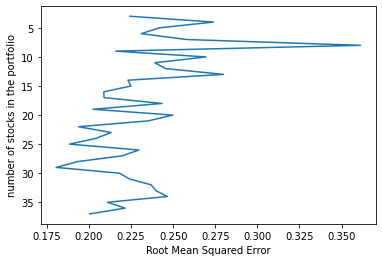

In [0]:
# Plot Efficient Deep Frontier

rmse = [e/len(cac40['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(3,38,1))) 
plt.xlabel('Root Mean Squared Error')
plt.ylabel('Nombre de stock dans le portefeuille')

# *B. Battre l'indice CAC 40 * 

La pahse 1 est la meme que ci dessus

**Phase 2. Etalonnage**
Ici, contrairement à la partie A, on veut fixer l'objectif de battre l'indice. Ainsi, on va odifier les données cibles pendant la phase d'étalonnage en remplaçant tous les retours inférieurs à -5% par exactement 5% , ce qui vise à créer un tracker d'index avec anti-corrélation dans les périodes de fortes baisses.

Text(0.5, -0.3, ' ')

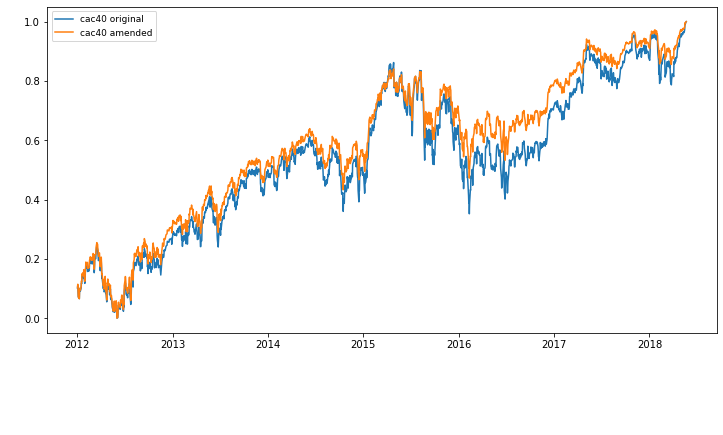

In [0]:
# from -5% to 5%
y_amended = cac40['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = cac40['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison

plt.clf
plt.figure(figsize=(12,6))
plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(cac40['calibrate']['lp']).values),label='cac40 original')
plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(lp_amended).values),label='cac40 amended')
plt.legend(loc='best', fontsize=9)
plt.xlabel(' ', fontsize=12)
plt.ylabel(' ', fontsize=12)
plt.title(" ", fontsize=15, loc='center', y=-0.3)


In [0]:
cac40_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [0,10,20]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index =ranking[0:s] # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    x_bis = stock['validate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    dl_scaler[s].fit(x_bis)
    x = dl_scaler[s].transform(x)  
    x_bis=  dl_scaler[s].transform(x_bis)

    deep_learner.fit(x, y, shuffle=False, epochs=100, batch_size = 10)    # fit the model
    deep_learner.save('beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    relative_percentage_bis= copy.deepcopy(deep_learner.predict(x_bis))
    relative_percentage_bis[0] = 0
    relative_percentage_bis= (relative_percentage_bis /100) + 1

    cac40_predict['calibrate'][s] = cac40['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((cac40_predict['calibrate'][s] - lp_amended)) # compare with amended last price


Epoch 1/100
1630/1630 [==============================] - 0s 110us/step - loss: 0.1278
Epoch 2/100
1630/1630 [==============================] - 0s 84us/step - loss: 0.0461
Epoch 3/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0340
Epoch 4/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0290
Epoch 5/100
1630/1630 [==============================] - 0s 83us/step - loss: 0.0261
Epoch 6/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0242
Epoch 7/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0228
Epoch 8/100
1630/1630 [==============================] - 0s 80us/step - loss: 0.0216
Epoch 9/100
1630/1630 [==============================] - 0s 79us/step - loss: 0.0206
Epoch 10/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0198
Epoch 11/100
1630/1630 [==============================] - 0s 77us/step - loss: 0.0190
Epoch 12/100
1630/1630 [==============================] - 0s 7

S10 2-norm difference:  116.09079
S20 2-norm difference:  103.49662
S30 2-norm difference:  100.15628


Text(0.5, -0.3, ' ')

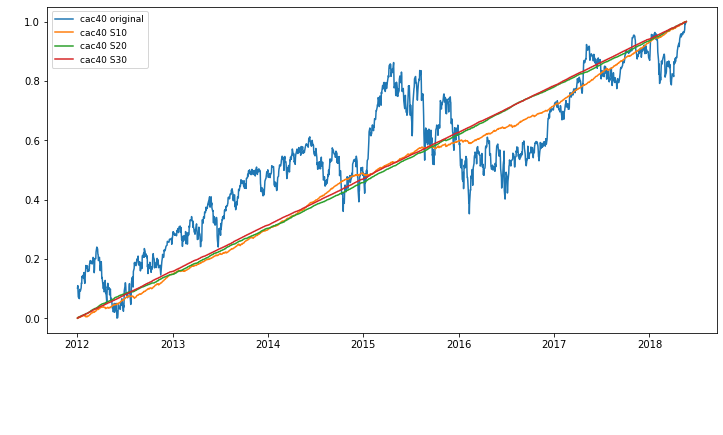

In [0]:
# plot results and 2-norm differences 

scaler=MinMaxScaler(feature_range=(0,1))

plt.clf
plt.figure(figsize=(12,6))
plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(cac40['calibrate']['lp']).values),label='cac40 original')
for s in [10,20,30]:
    plt.plot(cac40_file.index[:training_len],scaler.fit_transform(pd.DataFrame(cac40_predict['calibrate'][s]).values),label='cac40 S'+str(s))
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    
plt.legend(loc='best', fontsize=9)
plt.xlabel(' ', fontsize=12)
plt.ylabel(' ', fontsize=12)
plt.title(" ", fontsize=15, loc='center', y=-0.3)


In [0]:
pd.Series(cac40_predict['calibrate'][10])

0       3222.300049
1       3222.321533
2       3222.344238
3       3222.371582
4       3222.321533
           ...     
1625    3242.285889
1626    3242.297363
1627    3242.316895
1628    3242.307861
1629    3242.322021
Length: 1630, dtype: float32

**Phase 3. Validation**

In [0]:
for non_communal in [0,10,20]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index =ranking[0:s] # portfolio index
    cac40_predict['validate'][s] = cac40['validate']['lp'][0] * (relative_percentage_bis.cumprod()) 



Text(0.5, -0.3, ' ')

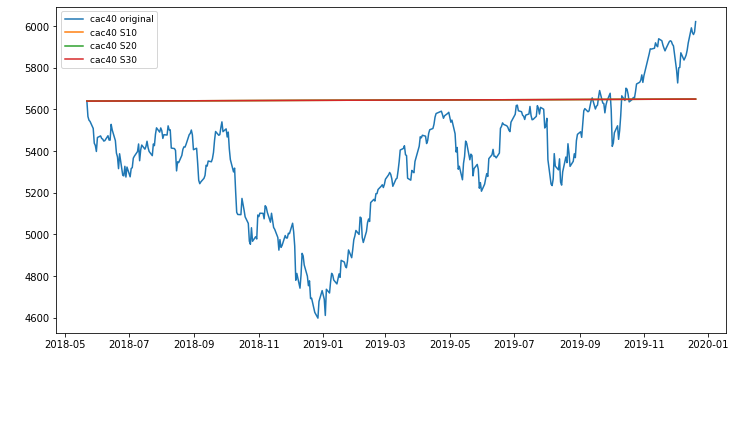

In [0]:
#La encore, on veut à quels points ces trois portefeuilles sont sembleble au CAC 40
plt.clf
plt.figure(figsize=(12,6))
plt.plot(cac40_file.index[training_len-1:],cac40['validate']['lp'],label='cac40 original')
for s in [10,20,30]:
    plt.plot(cac40_file.index[training_len-1:],cac40_predict['validate'][s],label='cac40 S'+str(s))
   
    
plt.legend(loc='best', fontsize=9)
plt.xlabel(' ', fontsize=12)
plt.ylabel(' ', fontsize=12)
plt.title(" ", fontsize=15, loc='center', y=-0.3)

#Cette fois si, ne réplique pas du tout le portefeuille
